In [1092]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['psd', 'cov']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [1094]:
import numpy as np
import scipy.io

In [1095]:
m = scipy.io.loadmat('/Users/kwonjh0825/HCI/data/BCICIV_calib_ds1g.mat', struct_as_record=True)

sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape                               

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]      
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]         # class labels
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)

In [1096]:
n = scipy.io.loadmat('/content/drive/MyDrive/CodeData/HCI/data/BCICIV_eval_ds1g.mat', struct_as_record=True)

sample_rate_test = n['nfo']['fs'][0][0][0][0]
EEG_test = n['cnt'].T
nchannels_test, nsamples_test = EEG.shape                               

channel_names_test = [s[0] for s in n['nfo']['clab'][0][0][0]]      
labels = np.zeros((1, nsamples), int)

cl_lab_test = [s[0] for s in n['nfo']['classes'][0][0][0]]         # class labels
cl1_test = cl_lab_test[0]
cl2_test = cl_lab_test[1]
nclasses_test = len(cl_lab_test)

In [1097]:
trials = {}

# Time window(in samples) to extract for each trial
win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

# length of the time window
nsamples = len(win)

# loop over the classes (right, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):

  # extract the onsets for the classes
  cl_onsets = event_onsets[event_codes==code]
  
  # allocate memory for trials
  trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))

  # extract each trial
  for i, onset in enumerate(cl_onsets):
    trials[cl][:,:,i] = EEG[:, win+onset]

print('shape of trials[cl1]:', trials[cl1].shape)
print('shape of trials[cl2]:', trials[cl2].shape)

shape of trials[cl1]: (59, 200, 100)
shape of trials[cl2]: (59, 200, 100)


In [1098]:
tests = {}

# Time window(in samples) to extract for each trial
win_test = np.arange(int(0.5*sample_rate_test), int(2.5*sample_rate_test))

# length of the time window
nsamples_test = len(win_test)

# loop over the classes (right, foot)
for cl, code in zip(cl_lab_test, np.unique(event_codes)):

  # extract the onsets for the classes
  cl_onsets = event_onsets[event_codes==code]
  
  # allocate memory for trials
  tests[cl] = np.zeros((nchannels_test, nsamples_test, len(cl_onsets)))

  # extract each trial
  for i, onset in enumerate(cl_onsets):
    tests[cl][:,:,i] = EEG[:, win+onset]

print('shape of tests[cl1]:', tests[cl1].shape)
print('shape of tests[cl2]:', tests[cl2].shape)

shape of tests[cl1]: (59, 200, 100)
shape of tests[cl2]: (59, 200, 100)


In [1099]:
from matplotlib import mlab

#PSD
def psd(trials):
  ntrials = trials.shape[2]
  trials_PSD = np.zeros((nchannels, 101, ntrials))

  for trial in range(ntrials):
    for ch in range(nchannels):
      (PSD, freqs)= mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
      trials_PSD[ch,:,trial] = PSD.ravel()

  return trials_PSD, freqs


In [1100]:
psd_r, freqs = psd(trials[cl1])
psd_f, freqs = psd(trials[cl2])
trials_PSD = {cl1:psd_r, cl2:psd_f}

psd_r_t, freqs_t = psd(tests[cl1_test])
psd_f_t, freqs_t = psd(tests[cl2_test])
tests_PSD = {cl1_test: psd_r_t, cl2_test:psd_f_t}

In [1134]:
print(trials_PSD["left"] == tests_PSD["left"])

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

In [1101]:
import matplotlib.pyplot as plt

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
  plt.figure(figsize=(12, 5))
  nchans = len(chan_ind)

  nrows = int(np.ceil(nchans/3))
  ncols = min(3, nchans)

  for i, ch in enumerate(chan_ind):
    plt.subplot(nrows,ncols, i+1)

    for cl in trials.keys():
      plt.plot(freqs, np.mean(trials_PSD[cl][ch, :, :], axis=1), label=cl)

      plt.xlim(1, 30)
      if maxy != None:
        plt.ylim(0, maxy)

      plt.grid()
      plt.xlabel('frequency (Hz)')
      if chan_lab == None:
        plt.title('channel %d'%(ch+1))
      else: 
        plt.title(chan_lab[i])

      plt.legend()

  plt.tight_layout()

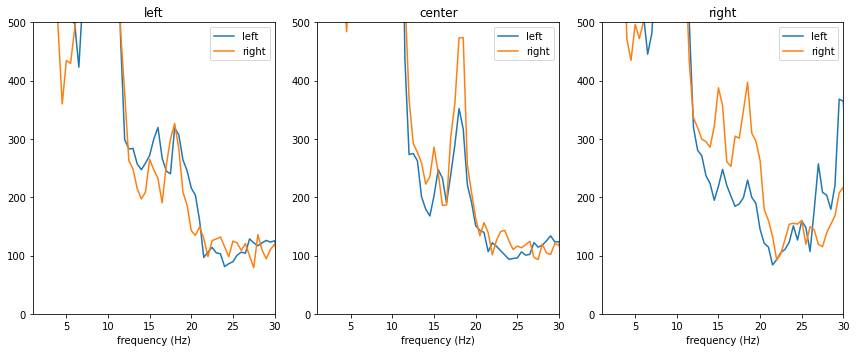

In [1102]:
plot_psd(trials_PSD, freqs, [channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']], 
         chan_lab=['left','center','right'], maxy=500)

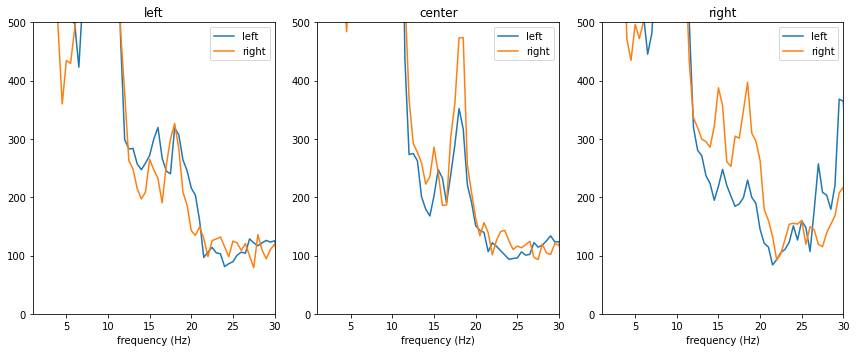

In [1103]:
plot_psd(tests_PSD, freqs_t, [channel_names_test.index(ch) for ch in ['C3', 'Cz', 'C4']], 
         chan_lab=['left','center','right'], maxy=500)

In [1104]:
#Bandpass filtering

import scipy.signal

def bandpass(trials, lo, hi, sample_rate):
  a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

  ntrials = trials.shape[2]
  trials_filt = np.zeros((nchannels, nsamples, ntrials))
  for i in range(ntrials):
    trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
  return trials_filt

In [1105]:
trials_filt = {cl1: bandpass(trials[cl1], 8, 15, sample_rate), cl2: bandpass(trials[cl2], 8, 15, sample_rate)}

trials_filt[cl1].shape

(59, 200, 100)

In [1106]:
tests_filt = {cl1: bandpass(tests[cl1_test], 8, 15, sample_rate_test), cl2: bandpass(tests[cl2_test], 8, 15, sample_rate_test)}

tests_filt[cl1].shape

(59, 200, 100)

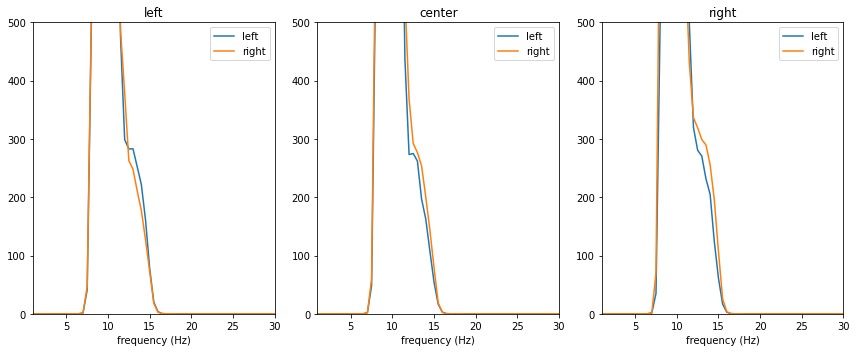

In [1107]:
psd_r, freqs = psd(trials_filt[cl1])
psd_f, freqs = psd(trials_filt[cl2])

trials_PSD = {cl1: psd_r, cl2:psd_f}

plot_psd(trials_PSD, freqs, [channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']], 
         chan_lab = ['left', 'center', 'right'], maxy=500)

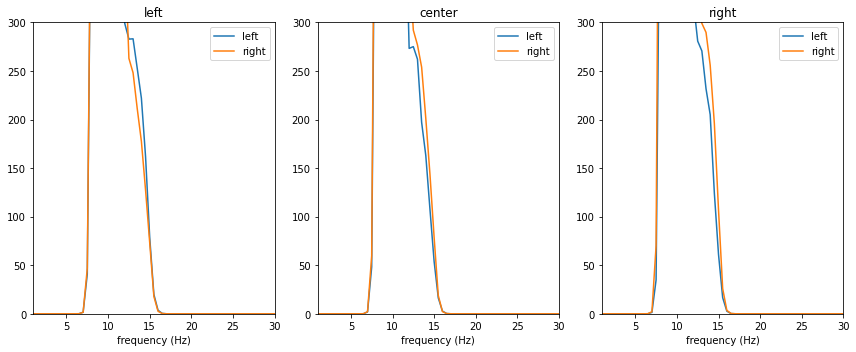

In [1108]:
psd_r_t, freqs_t = psd(tests_filt[cl1])
psd_f_t, freqs_t = psd(tests_filt[cl2])

tests_PSD = {cl1: psd_r_t, cl2:psd_f_t}

plot_psd(tests_PSD, freqs_t, [channel_names_test.index(ch) for ch in ['C3', 'Cz', 'C4']], 
         chan_lab = ['left', 'center', 'right'], maxy=300)

In [1109]:
def logvar(trials):
  return np.log(np.var(trials, axis=1))

In [1110]:
trials_logvar = {cl1: logvar(trials_filt[cl1]), cl2:logvar(trials_filt[cl2])}

trials_logvar[cl1].shape

(59, 100)

In [1111]:
# tests_logvar = {cl1: logvar(tests_filt[cl1_test]), cl2: logvar(tests_filt[cl2_test])}
# tests_logvar[cl1].shape

In [1112]:
def plot_logvar(trials):
    plt.figure(figsize=(12,5))
    
    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=1)
    y1 = np.mean(trials[cl2], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend(cl_lab)

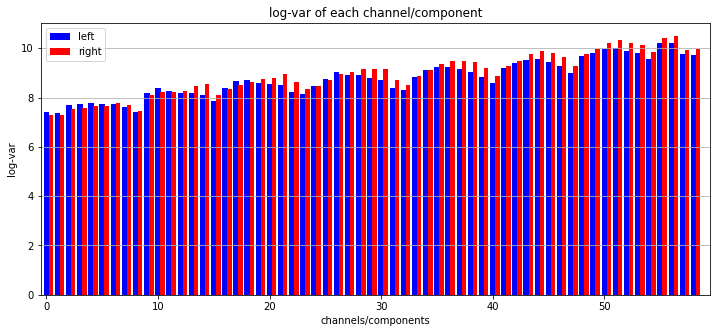

In [1113]:
plot_logvar(trials_logvar)

In [1114]:
from numpy import linalg

#CSP
def cov(trials):
  ntrials = trials.shape[2]
  covs = [trials[:,:,i].dot(trials[:,:,i].T)/nsamples for i in range(ntrials)]
  return np.mean(covs, axis=0)

def whitening(sigma):
  U, l, _ = linalg.svd(sigma)
  return U.dot(np.diag(l**-0.5))

def csp(trials_r, trials_f):
  cov_r = cov(trials_r)
  cov_f = cov(trials_f)
  P = whitening(cov_r+cov_f)
  B, _, _ = linalg.svd(P.T.dot(cov_f).dot(P))
  W = P.dot(B)
  return W

def apply_mix(W, trials):
  ntrials = trials.shape[2]
  trials_csp = np.zeros((nchannels, nsamples, ntrials))
  for i in range(ntrials):
    trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
  return trials_csp

In [1115]:
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]), cl2:apply_mix(W, trials_filt[cl2])}

W.shape

(59, 59)

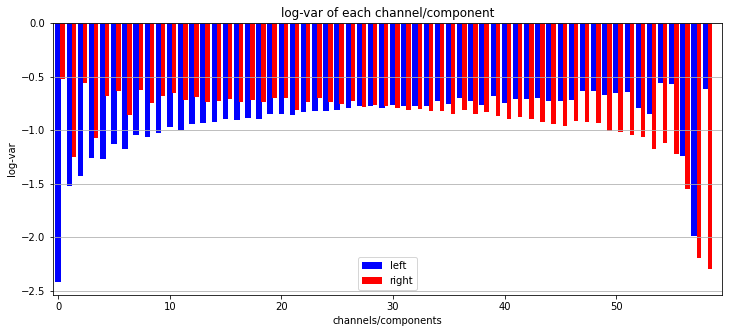

In [1116]:
trials_logvar = {cl1:logvar(trials_csp[cl1]), cl2: logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)

In [1127]:
W_test = csp(tests[cl1], tests[cl2])
tests_csp = {cl1: apply_mix(W_test, tests[cl1]), cl2:apply_mix(W, tests[cl2])}

W.shape

IndexError: ignored

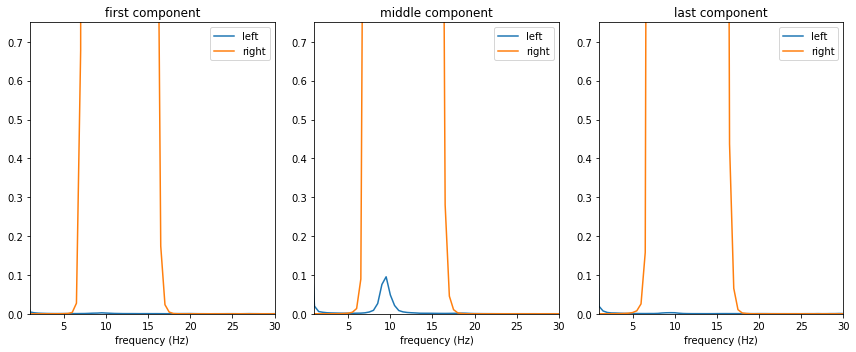

In [1118]:
psd_r, freqs = psd(trials_csp[cl1])
psf_f, freqs = psd(trials_csp[cl2])

trials_PSD = {cl1: psd_r, cl2: psd_f}

plot_psd(trials_PSD, freqs, [0, 28, -1], chan_lab=['first component', 'middle component', 'last component'], maxy=0.75)

In [ ]:
psd_r_t, freqs_t = psd(tests)

In [1119]:
def plot_scatter(left, foot):
    plt.figure()
    plt.scatter(left[0,:], left[-1,:], color='b')
    plt.scatter(foot[0,:], foot[-1,:], color='r')
    plt.xlabel('Last component')
    plt.ylabel('First component')
    plt.legend(cl_lab)

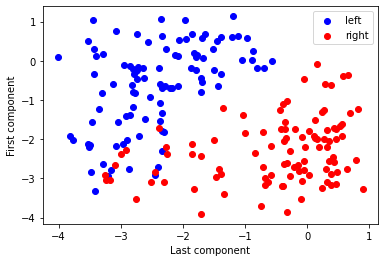

In [1120]:
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

In [1121]:
#LDA
def train_lda(class1, class2):
  nclasses = 2
  nclass1 = class1.shape[0]
  nclass2 = class2.shape[0]

  prior1 = nclass1 / float(nclass1 + nclass2)
  prior2 = nclass2 / float(nclass1 + nclass1)

  mean1 = np.mean(class1, axis=0)
  mean2 = np.mean(class2, axis=0)
  
  class1_centered = class1 - mean1
  class2_centered = class2 - mean2
  
  cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
  cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)

  W = (mean2 - mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
  b = (prior1*mean1 + prior2*mean2).dot(W)

  return (W, b)

def apply_lda(test, W, b):
  ntrials = test.shape[1]

  prediction = []

  for i in range(ntrials):
    result = W.dot(test[:,i]) - b
    if result <= 0:
      prediction.append(1)
    else:
      prediction.append(2)

  return np.array(prediction)

In [1122]:
train_percentage = 0.5
# ntrain_r = int(trials_filt[cl1].shape[2] * train_percentage)
# ntrain_f = int(trials_filt[cl2].shape[2] * train_percentage)
# ntest_r = trials_filt[cl1].shape[2] - ntrain_r
# ntest_f = trials_filt[cl2].shape[2] - ntrain_f
train = {cl1: trials_filt[cl1][:,:,:], 
         cl2: trials_filt[cl2][:,:,:]}

tests = {cl1: tests[cl1][:,:,:], 
        cl2: tests[cl2][:,:,:]}
      
W = csp(train[cl1], train[cl2])
W_test = csp(tests[cl1], tests[cl2])

train[cl1] = apply_mix(W, train[cl1])
train[cl2] = apply_mix(W, train[cl2])
tests[cl1] = apply_mix(W_test, tests[cl1])
tests[cl2] = apply_mix(W_test, tests[cl2])

comp = np.array([0, -1])
train[cl1] = train[cl1][comp,:,:]
train[cl2] = train[cl2][comp,:,:]
tests[cl1] = tests[cl1][comp,:,:]
tests[cl2] = tests[cl2][comp,:,:]

train[cl1] = logvar(train[cl1])
train[cl2] = logvar(train[cl2])
tests[cl1] = logvar(tests[cl1])
tests[cl2] = logvar(tests[cl2])

In [1123]:
W,b = train_lda(train[cl1].T, train[cl2].T)

print('W:', W)
print('b:', b)

W: [ 3.22778541 -2.98532808]
b: -0.4064812234788828


(-2.2, 1.0)

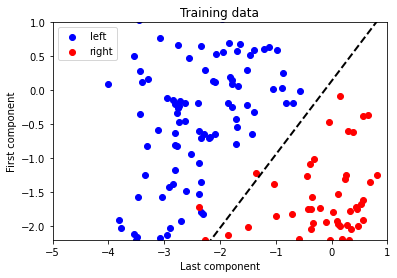

In [1124]:
# Scatterplot like before
plot_scatter(train[cl1], train[cl2])
title('Training data')

# Calculate decision boundary (x,y)
x = np.arange(-5, 1, 0.1)
y = (b - W[0]*x) / W[1]

# Plot the decision boundary
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)

(-5.0, -1.0)

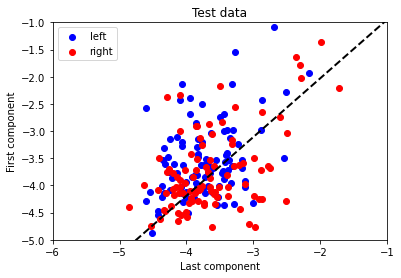

In [1125]:
plot_scatter(tests[cl1], tests[cl2])
title('Test data')
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-6, -1)
plt.ylim(-5, -1)

In [1126]:
# Print confusion matrix
conf = np.array([
    [(apply_lda(tests[cl1], W, b) == 1).sum(), (apply_lda(tests[cl2], W, b) == 1).sum()],
    [(apply_lda(tests[cl1], W, b) == 2).sum(), (apply_lda(tests[cl2], W, b) == 2).sum()],
])

print('Confusion matrix:')
print(conf)
print()
print('Accuracy: %.3f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))

Confusion matrix:
[[72 51]
 [28 49]]

Accuracy: 0.605
